# Pose Detection with DensePose

This notebook uses an open source project [facebookresearch/DensePose](https://github.com/facebookresearch/DensePose) to detect multi person poses on a test image.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install DensePose

Installing the DensePose seems to be very tricky. For more information, see [http://linkinpark213.com/2018/11/18/densepose-minesweeping/](http://linkinpark213.com/2018/11/18/densepose-minesweeping/).

First, we are going to install an Anaconda with some fixed dependencies:

In [ ]:
import os
from os.path import exists, join, basename, splitext

# install Anaconda Python 2.7 to control the dependencies
# see for more info: 
if not exists('anaconda2'):
  !wget -q https://repo.anaconda.com/archive/Anaconda2-2019.03-Linux-x86_64.sh
  !chmod +x Anaconda2-2019.03-Linux-x86_64.sh
  !bash ./Anaconda2-2019.03-Linux-x86_64.sh -b -f -p /content/anaconda2
  # set PATH environment variable
  os.environ['PATH'] = "/content/anaconda2/bin:" + os.environ['PATH']
  # install PyTorch
  !conda install -y pyyaml=3.12
  !conda install -y mkl-include
  !conda install -y pytorch=1.0.1 torchvision cudatoolkit=10.0 -c pytorch
  !ln -s /content/anaconda2/lib/python2.7/site-packages/torch/lib/ /content/anaconda2/lib/python2.7/site-packages/
  # install GCC 4.9
  !conda install -y -c serge-sans-paille gcc_49
  !ln -fs /content/anaconda2/lib/libmpfr.so /content/anaconda2/lib/libmpfr.so.4
  os.environ['CC'] = '/content/anaconda2/bin/gcc-4.9'
  os.environ['CXX'] = '/content/anaconda2/bin/g++-4.9'
  # protobuf 3.5
  #!apt-get -qq remove -y protobuf-compiler
  !conda install -y protobuf=3.5
  # pycocotools
  !conda install -y -c conda-forge pycocotools
  # some missing dependencies
  !pip install opencv-python==4.0.0.21 memory_profiler
  
# we need some headers from the pytorch source
if not exists('pytorch'):
  !git clone -q --depth 1 --recursive -b v1.0.1 https://github.com/pytorch/pytorch

Check whether the system dependencies are installed correctly:

In [ ]:
# some sanity checks
!conda --version
!protoc --version
!gcc-4.9 --version

Clone the DensePose project and build it:

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/facebookresearch/DensePose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone project
  !git clone -q --depth 1 $git_repo_url
  # install dependencies
  !cd $project_name && pip install -q -r requirements.txt
  # update CMakeLists.txt
  cmakelists_txt_content = """
cmake_minimum_required(VERSION 2.8.12 FATAL_ERROR)
set(Caffe2_DIR "/content/anaconda2/lib/python2.7/site-packages/torch/share/cmake/Caffe2/")
find_package(Caffe2 REQUIRED)

include_directories("/content/anaconda2/lib/python2.7/site-packages/torch/lib/include")
include_directories("/content/anaconda2/include")
include_directories("/content/pytorch")

add_library(libprotobuf STATIC IMPORTED)
set(PROTOBUF_LIB "/content/anaconda2/lib/libprotobuf.a")
set_property(TARGET libprotobuf PROPERTY IMPORTED_LOCATION "${PROTOBUF_LIB}")

if (${CAFFE2_VERSION} VERSION_LESS 0.8.2)
  # Pre-0.8.2 caffe2 does not have proper interface libraries set up, so we
  # will rely on the old path.
  message(WARNING
      "You are using an older version of Caffe2 (version " ${CAFFE2_VERSION}
      "). Please consider moving to a newer version.")
  include(cmake/legacy/legacymake.cmake)
  return()
endif()

# Add compiler flags.
set(CMAKE_C_FLAGS "${CMAKE_C_FLAGS} -std=c11")
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} -std=c++11 -O2 -fPIC -Wno-narrowing")

# Print configuration summary.
include(cmake/Summary.cmake)
detectron_print_config_summary()

# Collect custom ops sources.
file(GLOB CUSTOM_OPS_CPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cc)
file(GLOB CUSTOM_OPS_GPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cu)

# Install custom CPU ops lib.
add_library(
     caffe2_detectron_custom_ops SHARED
     ${CUSTOM_OPS_CPU_SRCS})

target_link_libraries(caffe2_detectron_custom_ops caffe2_library libprotobuf)
install(TARGETS caffe2_detectron_custom_ops DESTINATION lib)

# Install custom GPU ops lib, if gpu is present.
if (CAFFE2_USE_CUDA OR CAFFE2_FOUND_CUDA)
  # Additional -I prefix is required for CMake versions before commit (< 3.7):
  # https://github.com/Kitware/CMake/commit/7ded655f7ba82ea72a82d0555449f2df5ef38594
  list(APPEND CUDA_INCLUDE_DIRS -I${CAFFE2_INCLUDE_DIRS})
  CUDA_ADD_LIBRARY(
      caffe2_detectron_custom_ops_gpu SHARED
      ${CUSTOM_OPS_CPU_SRCS}
      ${CUSTOM_OPS_GPU_SRCS})

  target_link_libraries(caffe2_detectron_custom_ops_gpu caffe2_gpu_library libprotobuf)
  install(TARGETS caffe2_detectron_custom_ops_gpu DESTINATION lib)
endif()"""
  open(join(project_name, 'CMakeLists.txt'), 'w').write(cmakelists_txt_content)
  # build
  !cd $project_name && make
  !cd $project_name && make ops
  # download dense pose data
  !cd $project_name/DensePoseData && bash get_densepose_uv.sh

Check whether the DensePose installation was successful:

In [ ]:
!python2 $project_name/detectron/tests/test_spatial_narrow_as_op.py
!python2 $project_name/detectron/tests/test_zero_even_op.py

## Detect poses on a test image

Detect poses on the test image `demo_im.jpg` which is included in the DensePose repo:

In [ ]:
!cd $project_name && python2 tools/infer_simple.py \
    --cfg configs/DensePose_ResNet101_FPN_s1x-e2e.yaml \
    --output-dir DensePoseData/infer_out/ \
    --image-ext jpg \
    --wts https://dl.fbaipublicfiles.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl \
    DensePoseData/demo_data/demo_im.jpg

Visualize the result:

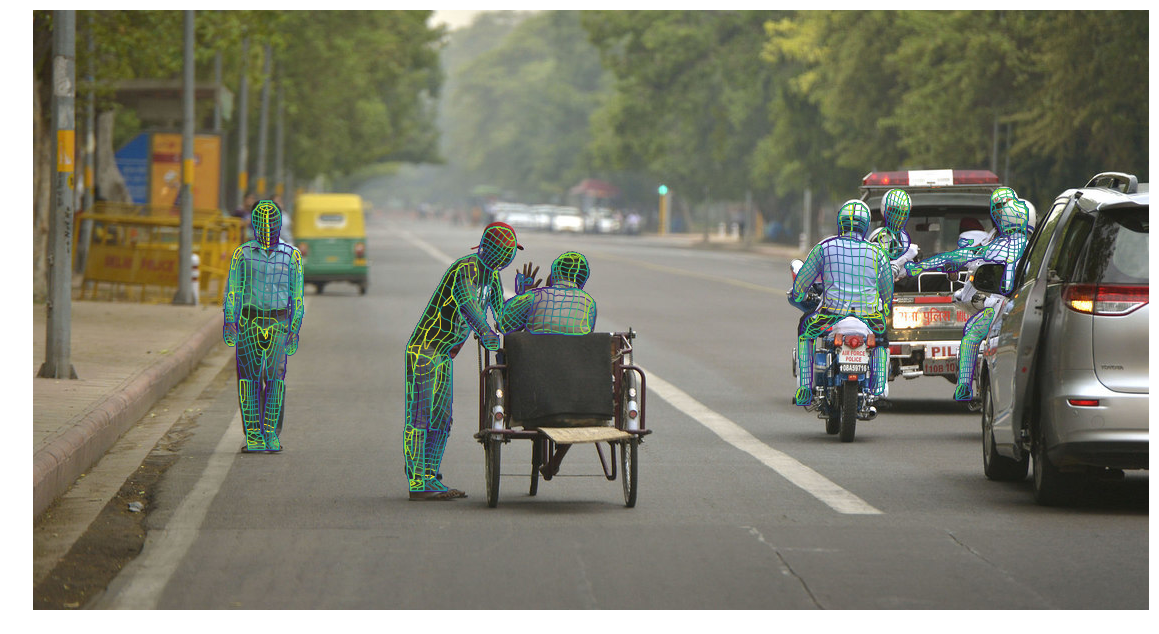

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

im  = cv2.imread(join(project_name, 'DensePoseData/demo_data/demo_im.jpg'))
IUV = cv2.imread(join(project_name, 'DensePoseData/infer_out/demo_im_IUV.png'))
INDS = cv2.imread(join(project_name, 'DensePoseData/infer_out/demo_im_INDS.png'),  0)

fig = plt.figure(figsize=[20, 20])
plt.imshow( im[:,:,::-1] )
plt.contour( IUV[:,:,1]/256.,10, linewidths = 1 )
plt.contour( IUV[:,:,2]/256.,10, linewidths = 1 )
plt.axis('off') ; plt.show()